In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
downloaded = drive.CreateFile({'id':'1PZlMKqtQ1vlURqGx0NBtoQ8yb2RTjuAy'}) # replace the id with id of file you want to access
downloaded.GetContentFile('oasis_longitudinal.csv') 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#DataSet load
df = pd.read_csv('oasis_longitudinal.csv')


In [5]:
#prepossessing
df = df.loc[df['Visit']==1]
df = df.reset_index(drop=True)
df['M/F'] = df['M/F'].replace(['F','M'], [0,1])
df['Group'] = df['Group'].replace(['Demented', 'Nondemented','Converted'], [1,0,1])
df.head()
df = df.drop(['Subject ID','MRI ID','Hand', 'Visit'], axis=1)
df[df==np.inf]=np.nan
df.fillna(df.mean(), inplace=True)

x = df.iloc[:,1:11]  #independent columns

y = df.iloc[:,0]  #target coloum

   Name      value
6   CDR  36.000000
5  MMSE  12.850211
1   M/F   3.891232
3  EDUC   3.821454
7  eTIV   1.116436
4   SES   0.323267
8  nWBV   0.019006
2   Age   0.000476
9   ASF   0.000247
Heatmap of Features 


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


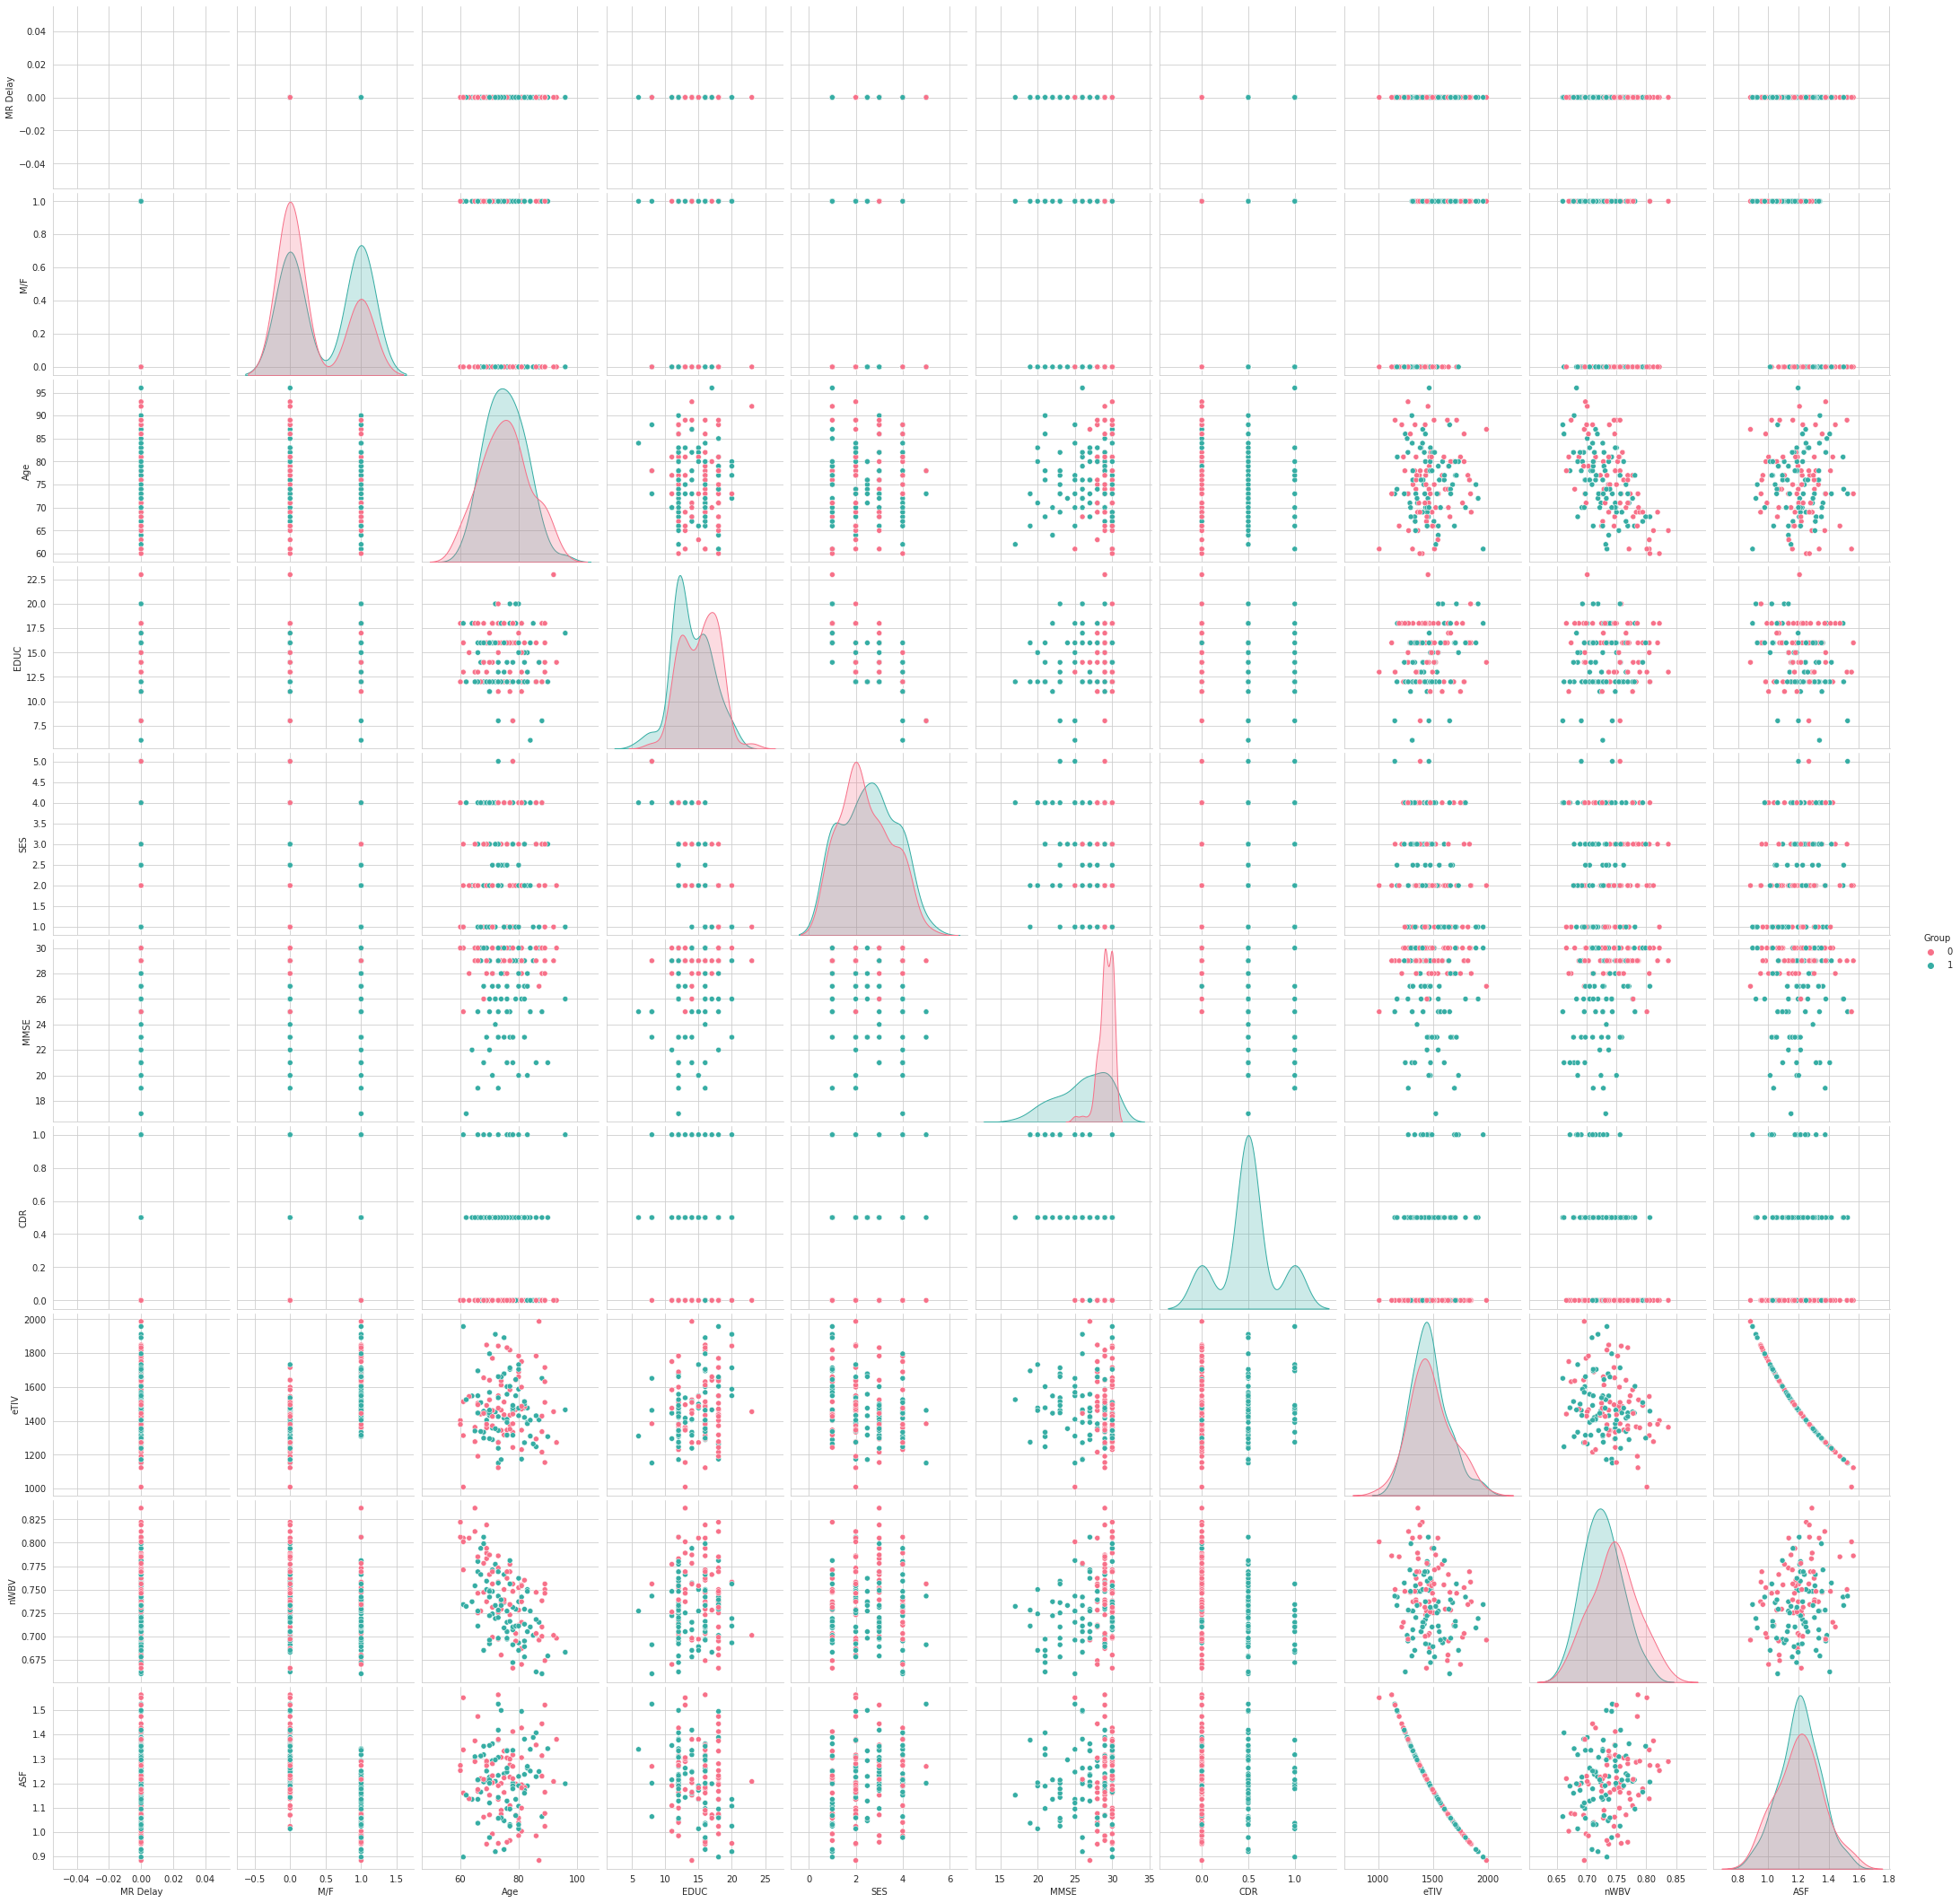

In [6]:
#Feature 
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Name','value']  #naming the dataframe columns
print(featureScores.nlargest(11,'value'))  #print 11 best features
print("Heatmap of Features ")
plt.close();
sns.set_style("whitegrid");
sns.pairplot(df, hue="Group", palette="husl", height=3);
plt.show()

In [7]:
#SVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc, classification_report



In [8]:
#Split
X_trainval, X_test, Y_trainval, Y_test = train_test_split(x, y,test_size=0.30,random_state=321)

#Feature Scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Model

best_score = 0
kfolds=5
acc = []
c_c=list(np.arange(0.00001,10,0.5))
g_g=list(np.arange(0.001,12,0.5))
for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']:
    for c_paramter in c_c:
        for gamma_paramter in g_g:
         
             svmModel = SVC(kernel=k_parameter, C=c_paramter, gamma=gamma_paramter)
             scores = cross_val_score(svmModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
             score = np.mean(scores)
             
             if score > best_score:
                best_score = score
                best_parameter_c = c_paramter
                best_parameter_gamma = gamma_paramter
                best_parameter_k = k_parameter
    
SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("HyperParameter Tuning Results")
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test AUC with the best parameter is", test_auc)
m = 'SVM'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

#Confusion matrix
ccm = confusion_matrix(Y_test,PredictedOutput) 
print ('Confusion Matrix :')
print(ccm) 
print ('Accuracy Score :',accuracy_score(Y_test,PredictedOutput))
print ('Report : ')
print (classification_report(Y_test,PredictedOutput))

HyperParameter Tuning Results
Best accuracy on cross validation set is: 0.9142857142857143
Best parameter for c is:  7.000009999999999
Best parameter for gamma is:  1.001
Best parameter for kernel is:  sigmoid
Test accuracy with the best parameters is 0.8666666666666667
Test recall with the best parameters is 0.8260869565217391
Test AUC with the best parameter is 0.8675889328063241
Confusion Matrix :
[[20  2]
 [ 4 19]]
Accuracy Score : 0.8666666666666667
Report : 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        22
           1       0.90      0.83      0.86        23

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        45



In [ ]:
### MLP

Y_train_n = Y_trainval
Y_test_n  = Y_test

X_train_n = X_trainval_scaled 
X_test_n  = X_test_scaled 


In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)

parameter_space = {
    'hidden_layer_sizes': [(20,30), (20,70,30), (20,70,70,30)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.00001, 0.05],
    'learning_rate': ['constant','adaptive', 'invscaling'] }

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train_n, Y_train_n)


# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  
y_true, y_pred = Y_test_n, clf.predict(X_test_n)


# creating the confusion matrix
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

cmlp = confusion_matrix(y_true, y_pred) 
print ('Confusion Matrix :')
print(cmlp) 
print ('Accuracy Score :',accuracy_score(y_true,y_pred))
print ('Report : ')
print (classification_report(y_true,y_pred))


Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (20, 70, 30), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.762 (+/-0.257) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (20, 30), 'learning_rate': 'constant', 'solver': 'sgd'}
0.867 (+/-0.097) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (20, 30), 'learning_rate': 'constant', 'solver': 'adam'}
0.667 (+/-0.353) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (20, 30), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.829 (+/-0.168) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (20, 30), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.505 (+/-0.117) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (20, 30), 'learning_rate': 'invscaling', 'solver': 'sgd'}
0.829 (+/-0.168) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (20, 30), 'learning_rate': 'invscaling', 'solver': 'adam'}
0.743 (+/-0.081) for

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# New Section

In [ ]:
#Ensemble

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import EnsembleVoteClassifier

X_train_en = X_trainval_scaled
X_test_en  = X_test_scaled 
Y_train_en = Y_trainval
Y_test_en  = Y_test


en_svm = SVC(C=7.000009999999999, gamma= 1.001, kernel='sigmoid')

# {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (20, 70, 30), 'learning_rate': 'adaptive', 'solver': 'adam'}

en_mlp = MLPClassifier(activation='tanh',hidden_layer_sizes=(20,70,30), solver='adam',learning_rate='adaptive',alpha=0.05,max_iter=500 )

# create the ensemble model

eclf = EnsembleVoteClassifier(clfs=[en_svm, en_mlp],voting = 'hard')

labels = ['SVM', 'MLP', 'Ensemble']
for clf, label in zip([en_svm, en_mlp, eclf], labels):

     #validation performance
    scores = cross_val_score(clf, X_train_en, Y_train_en, cv=5, scoring='accuracy')
    
    print("Accuracy on cross validation using 5 flods : %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

#SVM  
En_model_svm = en_svm.fit(X_train_en, Y_train_en)
p_svm = En_model_svm.predict(X_test_en) 
cm_en_svm = confusion_matrix(Y_test_en,p_svm) 
print ('Confusion Matrix For SVM:')
print (cm_en_svm) 
print ('Accuracy Score :',accuracy_score(Y_test_en,p_svm))
print ('Report : ')
print (classification_report(Y_test_en,p_svm))


#MLP  
En_model_mlp = en_mlp.fit(X_train_en, Y_train_en)
p_mlp = En_model_mlp.predict(X_test_en) 
cm_en_mlp = confusion_matrix(Y_test_en,p_mlp) 
print ('Confusion Matrix For MLP:')
print (cm_en_mlp) 
print ('Accuracy Score :',accuracy_score(Y_test_en,p_mlp))
print ('Report : ')
print (classification_report(Y_test_en,p_mlp))

#Ensemble or Proposed model  
En_model_prop = eclf.fit(X_train_en, Y_train_en)
p_prop = En_model_prop.predict(X_test_en) 
cm_en_prop = confusion_matrix(Y_test_en,p_prop) 
print ('Confusion Matrix For Proposed Model:')
print (cm_en_prop) 
print ('Accuracy Score :',accuracy_score(Y_test_en,p_prop))
print ('Report : ')
print (classification_report(Y_test_en,p_prop))


#sns.heatmap(cm_en_prop,annot=True,cbar=False)
#plt.ylabel('True Label')
#plt.xlabel('Predicted Label')
#plt.title('Confusion Matrix')
   

Accuracy on cross validation using 5 flods : 0.91 (+/- 0.07) [SVM]


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy on cross validation using 5 flods : 0.85 (+/- 0.06) [MLP]


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy on cross validation using 5 flods : 0.90 (+/- 0.06) [Ensemble]
Confusion Matrix For SVM:
[[20  2]
 [ 4 19]]
Accuracy Score : 0.8666666666666667
Report : 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        22
           1       0.90      0.83      0.86        23

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        45



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Confusion Matrix For MLP:
[[20  2]
 [ 3 20]]
Accuracy Score : 0.8888888888888888
Report : 
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        22
           1       0.91      0.87      0.89        23

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45

Confusion Matrix For Proposed Model:
[[22  0]
 [ 4 19]]
Accuracy Score : 0.9111111111111111
Report : 
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        22
           1       1.00      0.83      0.90        23

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
